## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

## Reading the Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
df = train.copy()

## Data Exploration & Preprocessing

In [4]:
df.shape

(8523, 12)

*The dataset contains 8523 records and 12 features.*

In [5]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

*We have quite a few null values in Item_Weight and Outlet_Size which will have to be treated.*

In [7]:
df.duplicated().sum()

0

*There are no duplicate records.*

In [8]:
len(df['Item_Identifier'].unique())

1559

In [9]:
len(df['Outlet_Identifier'].unique())

10

*Item_Identifier and Outlier_identifier are not all unique features, hence they can't be entirely removed.*

In [10]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

*LF, low fat and Low Fat, all represent the same category of fat content in products.*

In [11]:
def correction(val):
    if val == 'LF' or val == 'low fat':
            return 'Low Fat'
    elif val == 'reg':
            return 'Regular'
    return val

In [12]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].apply(correction)
test['Item_Fat_Content'] = test['Item_Fat_Content'].apply(correction)

### Treating NA values

*Items with the same identifier will have the same weight, this fact can be used to impute null records of weight by matching the item id.*

In [13]:
item_weight_mapping = df.loc[~df['Item_Weight'].isna(), ['Item_Identifier', 'Item_Weight']].set_index('Item_Identifier')['Item_Weight'].to_dict()

df['Item_Weight'] = df.apply(lambda row: item_weight_mapping.get(row['Item_Identifier'], row['Item_Weight']), axis = 1)
test['Item_Weight'] = test.apply(lambda row: item_weight_mapping.get(row['Item_Identifier'], row['Item_Weight']), axis = 1)

*Filling in the most likely Outlet_Size per Outlet_Type in null Outlet_Size records.*

In [14]:
mode_per_outlet_type = df.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.mode().iloc[0])

df['Outlet_Size'] = df.apply(lambda row: mode_per_outlet_type[row['Outlet_Type']] if pd.isna(row['Outlet_Size']) else row['Outlet_Size'], axis = 1)
test['Outlet_Size'] = test.apply(lambda row: mode_per_outlet_type[row['Outlet_Type']] if pd.isna(row['Outlet_Size']) else row['Outlet_Size'], axis = 1)

In [15]:
df.isna().sum().sum()

4

In [16]:
df.dropna(inplace = True)
test.dropna(inplace = True)

*Finally, we have the following features*

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


*Grouping numerical columns (except Outlet_Establishment_Year) for further analysis.*

In [18]:
num_cols = [col for col in df.columns if (df[col].dtype == 'int64' or df[col].dtype == 'float64') and (col != 'Outlet_Establishment_Year')]

In [19]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


C:\Users\kunja\AppData\Local\Temp\ipykernel_10880\359632792.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

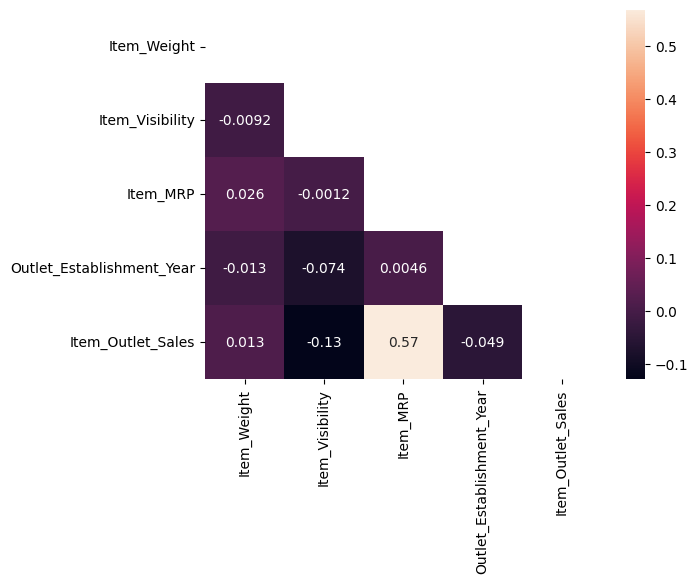

In [20]:
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr, annot = True, mask = mask)

*None of the features seems to have a really strong correlation with the target variable. However, as expected, Item_MRP has the strongest correlation among the other features.*

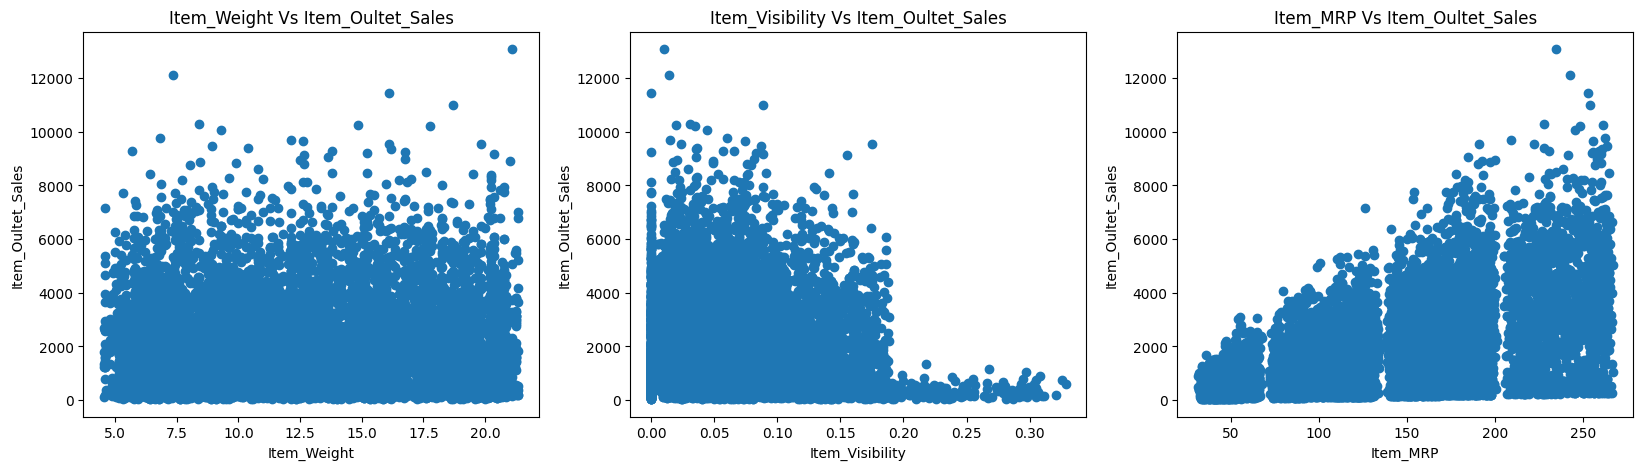

In [21]:
plt.figure(figsize = (20, 5))
for index, col in enumerate(num_cols):
    if col != 'Item_Outlet_Sales':
        ax = plt.subplot(1, 3, index + 1)
        ax.scatter(x = df[col], y = df['Item_Outlet_Sales'])
        ax.set_xlabel(col)
        ax.set_ylabel('Item_Oultet_Sales')
        ax.set_title(col + ' Vs Item_Oultet_Sales')

*An interesting pattern of vertical bar - like structures is noticeable between Item_MRP and the target variable, hence, discretising it.*

In [22]:
list(df.columns).index('Item_MRP')

5

In [23]:
df['Price_disc'] = ''
list(df.columns).index('Price_disc')

12

In [24]:
for ind in range(len(df.iloc[:, 5])):
    val = df.iloc[ind, 5]
    if val >= 25 and val < 75:
        df.iloc[ind, 12] = 'very low'
    elif val >= 75  and val < 125:
        df.iloc[ind, 12] = 'low'
    elif val >= 125 and val < 175:
        df.iloc[ind, 12] = 'moderate'
    elif val >= 175 and val < 325:
        df.iloc[ind, 12] = 'high'
    else:
        df.iloc[ind, 12] = 'very high'

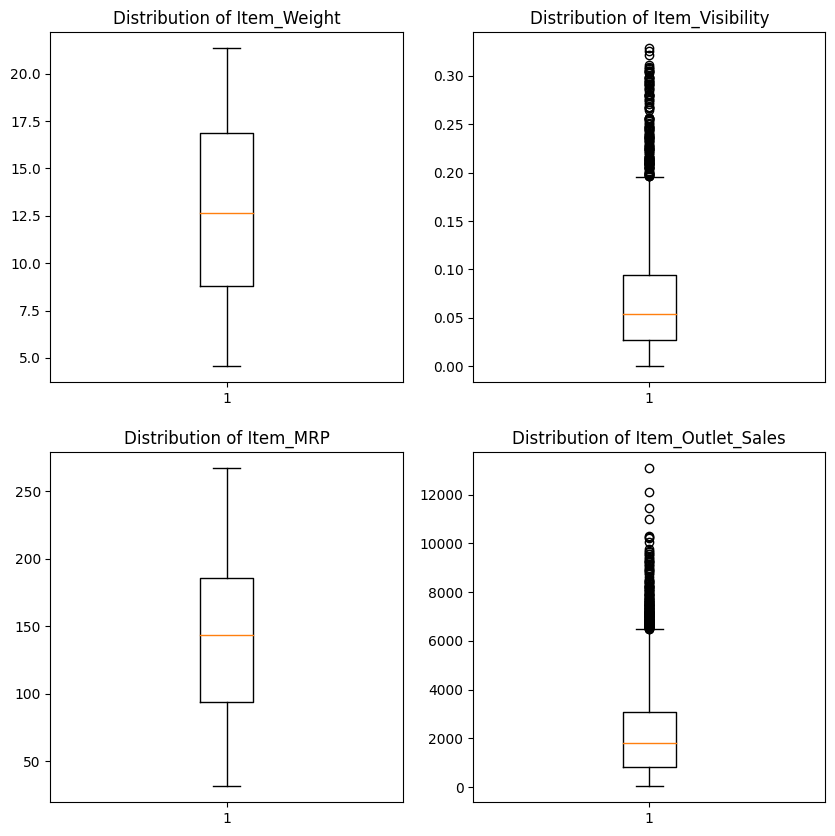

In [25]:
plt.figure(figsize = (10, 10))
for index, col in enumerate(num_cols):
        ax = plt.subplot(2, 2, index + 1)
        ax.boxplot(x = df[col])
        ax.set_title('Distribution of ' + col)

*Item_Weight and Item_Visibility tend to have a normal distribution while Item_Visibility and the target variables - Item_Outlet_Sales have quite a few outliers.*

## Treating Outliers

In [26]:
q3 = np.quantile(df['Item_Visibility'], 0.75)
q1 = np.quantile(df['Item_Visibility'], 0.25)
high_thresh = q3 + 1.5*(q3 - q1)
df.loc[df['Item_Visibility'] > high_thresh, 'Item_Visibility'] = high_thresh

In [27]:
q3 = np.quantile(df['Item_Outlet_Sales'], 0.75)
q1 = np.quantile(df['Item_Outlet_Sales'], 0.25)
high_thresh = q3 + 1.5*(q3 - q1)
df.loc[df['Item_Outlet_Sales'] > high_thresh, 'Item_Outlet_Sales'] = high_thresh

*The values greater than upper threshold have been replaced with the upper threshold.*

### Visualising the distribution of categorical features

<Axes: xlabel='Price_disc', ylabel='count'>

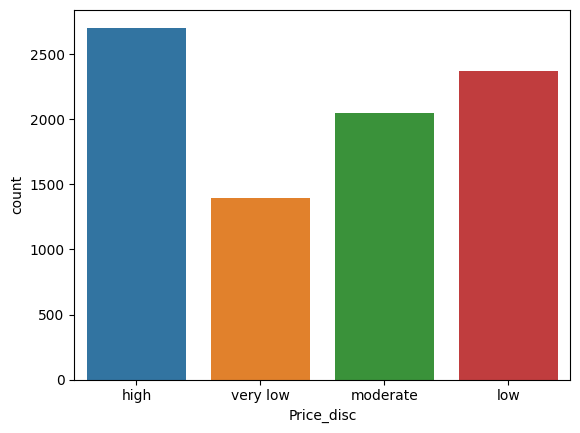

In [28]:
sns.countplot(x = 'Price_disc', data = df)

<BarContainer object of 8519 artists>

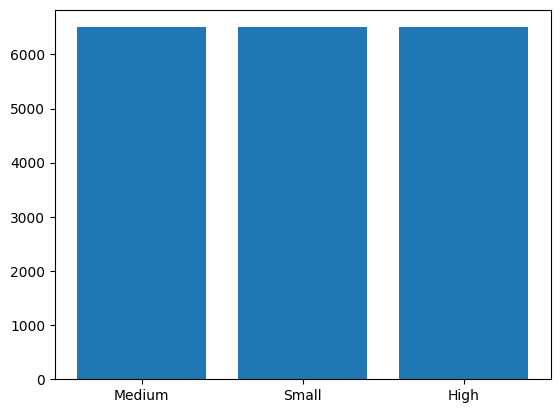

In [29]:
plt.bar(x = df['Outlet_Size'], height = df['Item_Outlet_Sales'])

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Supermarket Type1'),
  Text(1, 0, 'Supermarket Type2'),
  Text(2, 0, 'Grocery Store'),
  Text(3, 0, 'Supermarket Type3')])

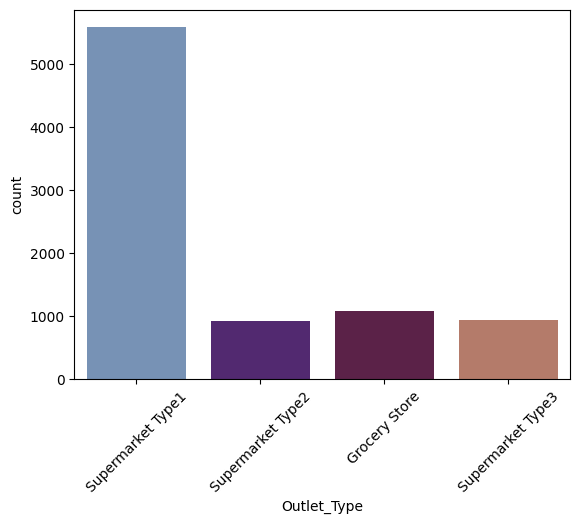

In [30]:
sns.countplot(x = 'Outlet_Type', data = df, palette = 'twilight')
plt.xticks(rotation = 45)

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

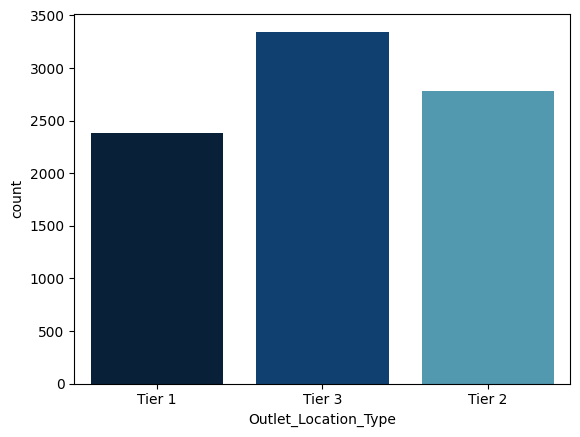

In [31]:
sns.countplot(x = 'Outlet_Location_Type', data = df, palette = 'ocean')

<Axes: xlabel='Outlet_Size', ylabel='count'>

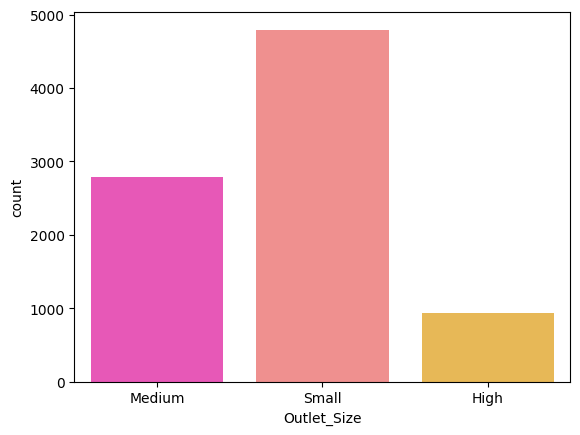

In [32]:
sns.countplot(x = 'Outlet_Size', data = df, palette = 'spring')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'OUT049'),
  Text(1, 0, 'OUT018'),
  Text(2, 0, 'OUT010'),
  Text(3, 0, 'OUT013'),
  Text(4, 0, 'OUT027'),
  Text(5, 0, 'OUT045'),
  Text(6, 0, 'OUT017'),
  Text(7, 0, 'OUT046'),
  Text(8, 0, 'OUT035'),
  Text(9, 0, 'OUT019')])

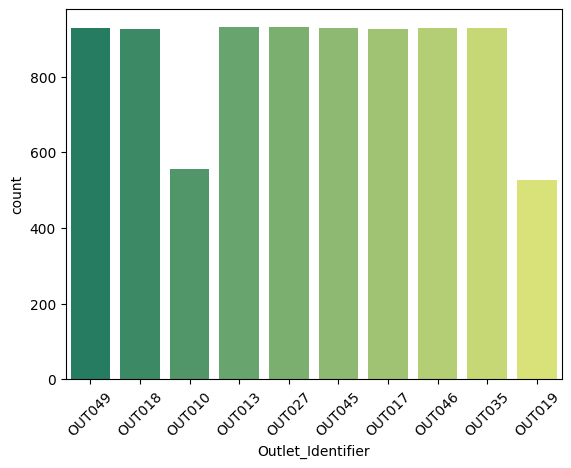

In [33]:
sns.countplot(x = 'Outlet_Identifier', data = df, palette = 'summer')
plt.xticks(rotation = 45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Dairy'),
  Text(1, 0, 'Soft Drinks'),
  Text(2, 0, 'Meat'),
  Text(3, 0, 'Fruits and Vegetables'),
  Text(4, 0, 'Household'),
  Text(5, 0, 'Baking Goods'),
  Text(6, 0, 'Snack Foods'),
  Text(7, 0, 'Frozen Foods'),
  Text(8, 0, 'Breakfast'),
  Text(9, 0, 'Health and Hygiene'),
  Text(10, 0, 'Hard Drinks'),
  Text(11, 0, 'Canned'),
  Text(12, 0, 'Breads'),
  Text(13, 0, 'Starchy Foods'),
  Text(14, 0, 'Others'),
  Text(15, 0, 'Seafood')])

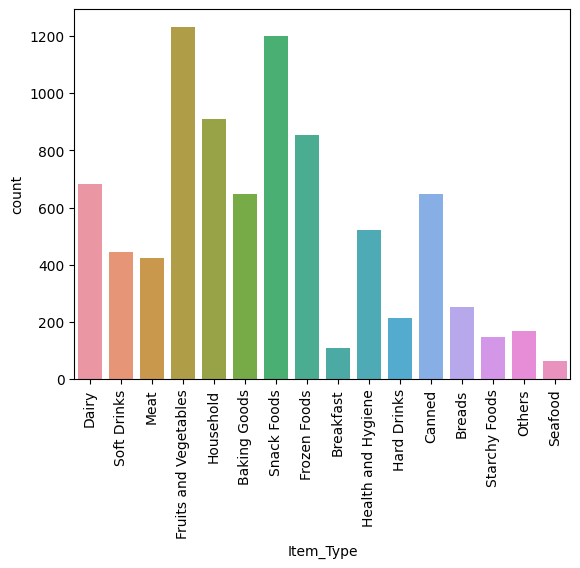

In [34]:
sns.countplot(x = 'Item_Type', data = df)
plt.xticks(rotation = 90)

<Axes: xlabel='Item_Fat_Content', ylabel='count'>

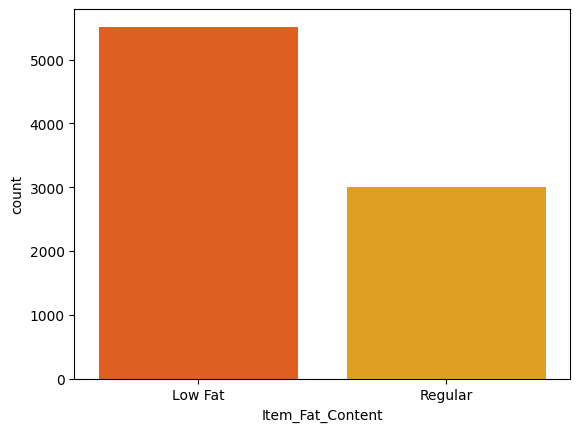

In [35]:
sns.countplot(x = 'Item_Fat_Content', data = df, palette = 'autumn')

## Final Data Prepraration

*Listing out the categorical features to be encoded*

In [36]:
to_encode = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Price_disc']

In [37]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Price_disc'],
      dtype='object')

In [38]:
X = df.drop('Item_Outlet_Sales', axis = 1)
y = df['Item_Outlet_Sales']

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in to_encode:
    X[col] = le.fit_transform(X[col])

*Train test Split*

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

In [41]:
num_cols.remove('Item_Outlet_Sales')
num_cols.remove('Item_MRP')

*Scaling the features*

In [42]:
sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.fit_transform(X_test[num_cols])

## Modelling

In [43]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [44]:
model.score(X_test, y_test)

0.5729112170678753